# Intermediate Bioinformatics for Parkinson’s Disease Genetics

* __Module V:__  Post-GWAS analyses on Parkinson's Disease risk: Heritability, Cross-Trait Genetic Correlations and Mendelian Randomization

* __Authors:__ Sara Bandres-Ciga on behalf of the Global Parkinson's Genetics Program (GP2) from Aligning Science Across Parkinson's (ASAP)

* __Estimated Computation and Runtime:__
    * Estimated Specifications: 4 CPUs, 15 GB memory, 250 GB Persistent Disk
    * Estimated Runtime: 3-4 h total

* __Date last updated:__ 20-JUL-2022

## Quick Description:


This notebook sets up to run post-GWAS analyses including heritability estimates through GCTA-GREML and LDSC, genetic correlations and Mendelian Randomization

## Background/Motivation:

Although Genome-wide Association Studies (GWAS) have been key to identify common variation linked to disease etiology, this methodology leaves a lot of information under the table. Post-GWAS methods are promising approaches to explore heritability linked to disease and unravel genetic correlations or causality across diseases.

Heritability is of particular interest in understanding traits that like PD are very complex in nature. Heritability can give initial clues as to the relative influences of genetics and environment, and it can give researchers a place to start teasing apart the factors that influence disease to develop predictive and preventive strategies. Narrow sense heritability is the fraction of phenotypic variance that can be attributed to variation in the additive effects of genes meaning that genetic alleles are going to contribute to a trait in a cumulative and equal manner, in the absence of dominant or recessive mechanisms. 

The advent of advanced genomic technologies and analysis tools allow us to ask fundamental questions regarding genetic variation and the extent to which traits are genetic. Once we know that a trait (in this case PD) is partially influenced by genetics, we can go beyond and study if PD is somehow linked to the etiology of other traits or influenced by other traits exploring cross-traits genetic correlations and causality.

## Workflow Summary:

  0. Set up environment.
  1. Narrow-sense heritability analyses
    - a) Genome-Complex Trait Analyses (GCTA-GREML)
    - b) Linkage Disequilibrium Score Regression (LDSC)
  2. Genome-wide cross-trait genetic correlations
  3. Mendelian Randomization

## Workflow:

### [0. Getting Started](#0)

This section goes through:
* Setting up Python libraries, data path variables, and functions
* Installing plink, gcta and R
* Copying existing PD summary statistics, imputed data and covariate files to workspace
* Formatting covariate files

### [1. Heritability analyses](#1)

This section goes through:
* Importing imputed genetic data from the European population into the workspace
* Format p-files into b-files
* Create a Genetic Relationship Matrix (GRM) based on segmented LD scores
* Run a Restricted Maximum Likelihood (REML) analysis with multiple GRMs
* Calculate heritability estimates using LDSC

### [2. Genetic correlations](#2)

This section goes through:
* Using GenomicSEM to calculate genetic correlations between PD and PD-age at onset

### [3. Mendelian Randomization (MR)](#3)

This section goes through:
* Multi-variant MR analyses between uric acid and PD risk
* MR - Sensitivity and Instrument strength analyses
* MR - Data visualization, Reverse causality, LOO

## 0. Getting started
<a id="0"></a>

### 0. Set up environment

In [1]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

In [2]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v2.5')
print(f'Path to AMP-PD v2.5 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v2.5 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

## GP2 v2.0
GP2_RELEASE_PATH = 'gs://gp2tier2/release2_06052022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v2.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

Billing and Workspace
Workspace Name: GP2 Bioinformatics Course 2
Billing Project: terra-9b559320
Workspace Bucket, where you can upload and download data: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914

AMP-PD v2.5
Path to AMP-PD v2.5 Clinical Data: gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
Path to AMP-PD v2.5 WGS Data: gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink

GP2 v2.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release2_06052022/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release2_06052022/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release2_06052022/imputed_genotypes


In [3]:
# Utility routine functions for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}')
    !$command
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

### 1. Install packages

In [4]:
%%capture
%%bash

cd /home/jupyter/
if test -e /home/jupyter/plink; then

echo "Plink is already installed in /home/jupyter/"
else
echo "Plink is not installed"
cd /home/jupyter

wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 

unzip -o plink_linux_x86_64_20190304.zip
mv plink plink1.9

fi

In [5]:
%%capture
%%bash

cd /home/jupyter/
if test -e /home/jupyter/plink2; then

echo "Plink2 is already installed in /home/jupyter/"
else
echo "Plink2 is not installed"
cd /home/jupyter/

wget http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip

unzip -o plink2_linux_x86_64_latest.zip

fi

In [6]:
%%bash
# chmod plink to make sure you have permission to run the program
chmod u+x /home/jupyter/plink1.9

In [7]:
%%bash
# chmod plink to make sure you have permission to run the program
chmod u+x /home/jupyter/plink2

In [8]:
%%capture
%%bash
# Download gcta64 from https://yanglab.westlake.edu.cn/software/gcta/#Download
# Upload executable into workspace (under Data)
# Copy gcta64 from workspace into working directory
gsutil cp gs://fc-b27d585d-787e-4197-a818-8eb080ef494e/gcta64 /home/jupyter/

In [9]:
%%bash
# chmod gcta64 to make sure you have permission to run the program
chmod u+x /home/jupyter/gcta64

In [10]:
! pip install rpy2 # Install R

In [11]:
%load_ext rpy2.ipython

## 1. Heritability analyses
<a id="1"></a>

### a) Genome-Complex Trait Analyses (GCTA-GREML)

In [ ]:
# Create a folder on your workspace
print("Making a working directory")
WORK_DIR = f'/home/jupyter/heritability/GCTA_GP2/'
shell_do(f'mkdir -p {WORK_DIR}') # f' stands for f-string which contains expressions inside brackets

In [ ]:
# Check directory where GP2 Tier 2 data is
print("List available imputed genotype information in GP2 (broken down by ancestry)")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_IMPUTED_GENO_PATH}')

In [ ]:
# Copy files from bucket to your workspace - Here we will use EUR as an example
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_IMPUTED_GENO_PATH}/EUR {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_META_RELEASE_PATH}/projected_pcs.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_CLINICAL_RELEASE_PATH}/master_key_release2_final.csv {WORK_DIR}')


In [ ]:
# Import manually files that you would like to copy in Terra and then transfer them into your notebook workspace
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp gs://fc-927e9f1a-8edc-420f-99b1-302bb53caacf/Release2_unrelated_individuals_PIHAT0125.txt {WORK_DIR}')


In [ ]:
%%bash

# Let's run it on all autosomes
for chnum in {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22};
do
    /home/jupyter/plink2 \
    --pfile /home/jupyter/heritability/GCTA_GP2/EUR/chr"$chnum"_EUR_release2 \
    --maf 0.05 \
    --threads 30 \
    --make-bed \
    --out /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr"$chnum"
done



In [ ]:
%%bash

# Heritability analyses
# Step 1: Run GRM on all autosomes 
## alternatively use --grm-cutoff 0.05 to deal with related individuals
for chnum in {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22};
do
    /home/jupyter/gcta64 \
    --bfile /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr"$chnum" --maf 0.05 \
    --threads 100 \
    --make-grm \
    --keep /home/jupyter/heritability/GCTA_GP2/Release2_unrelated_individuals_PIHAT0125.txt \
    --out /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr"$chnum"
done



In [ ]:
%%bash

# What outputs do we get?
ls /home/jupyter/heritability/GCTA_GP2/EUR/GRM*

In [ ]:
%%bash

head /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr1.grm.bin

In [ ]:
%%bash

head /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr11.grm.N.bin

In [ ]:
# %%bash

# head /home/jupyter/heritability/GCTA_GP2/EUR/GRM_chr11.grm.id

In [ ]:
# GP2 Tier 2 covariate file (master_key_release1)

WORK_DIR = '/home/jupyter/heritability/GCTA_GP2/'
FULL_PATH = WORK_DIR + '/master_key_release2_final.csv'

cov = pd.read_csv(FULL_PATH)
cov.rename(columns = {'GP2sampleID':'IID'}, inplace = True)
cov.columns
# cov.head()

In [ ]:
# Merge datasets by IID

WORK_DIR = '/home/jupyter/heritability/GCTA_GP2/'
FULL_PATH = WORK_DIR + 'projected_pcs.csv'
cov2 = pd.read_csv(FULL_PATH)
cov_final = cov2.merge(cov, on='IID') # Horizontal.

cov_final.loc[cov_final["sex_for_qc"] == "Male", "sex_for_qc"] = 0
cov_final.loc[cov_final["sex_for_qc"] == "Female", "sex_for_qc"] = 1
cov_final.loc[cov_final["Phenotype"] == "Control", "Phenotype"] = 0
cov_final.loc[cov_final["Phenotype"] == "PD", "Phenotype"] = 1
cov_final.loc[cov_final["Phenotype"] == "Other", "Phenotype"] = -9
cov_final.loc[cov_final["Phenotype"] == "Not Reported", "Phenotype"] = -9

cov_final.head()
pheno_df = cov_final[['FID','IID','Phenotype']]
sex_df = cov_final[['FID','IID','sex_for_qc']]
PCs_df = cov_final[['FID','IID','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]

pheno_df.to_csv('/home/jupyter/heritability/GCTA_GP2/gp2_pheno.txt', header=False, index=False, sep=" ")
sex_df.to_csv('/home/jupyter/heritability/GCTA_GP2/gp2_sex.txt', header=False, index=False, sep=" ")
PCs_df.to_csv('/home/jupyter/heritability/GCTA_GP2/gp2_pcs.txt', header=False, index=False, sep=" ")


In [ ]:
%%bash

WORK_DIR=/home/jupyter/heritability/GCTA_GP2/
cd $WORK_DIR

# Heritability analyses
# Step 2: REML analysis with multiple GRMs
# Input multi_grm.txt format: no headline; each line represents the prefix of a GRM file
# Input phenotype file: no headline; 3 columns (FID, IID, Pheno); coded 0 for controls and 1 for cases. Missing value should be represented by "-9" or "NA". 
# Input qcovar file: no headline; quantitative variables (FID, IID, PC1, PC2..)
# Input covar file: no headline; discrete variables (FID, IID, sex..)

ls ./EUR/*.grm.bin | sed 's/.grm.bin//g' > ./EUR/multi_GRMs.txt
/home/jupyter/gcta64 --reml --mgrm ./EUR/multi_GRMs.txt  --pheno gp2_pheno.txt --qcovar gp2_pcs.txt --covar gp2_sex.txt --prevalence 0.001 --out all_chr_reml --thread-num 20



### b) Linkage Disequilibrium Score Regression (LDSC)

In [12]:
# Create a folder on your workspace
print("Making a working directory")
WORK_DIR = f'/home/jupyter/heritability/LDSC_GP2/'
shell_do(f'mkdir -p {WORK_DIR}') # f' stands for f-string which contains expressions inside brackets

Making a working directory
Executing: mkdir -p /home/jupyter/heritability/LDSC_GP2/


In [13]:
# Check directory where GP2 Tier 2 data is
print("List available summary statistics")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_SUMSTAT_RELEASE_PATH}')

List available summary statistics
Executing: gsutil -u terra-9b559320 ls gs://gp2tier2/release2_06052022/summary_statistics
gs://gp2tier2/release2_06052022/summary_statistics/META5_no23_with_rsids2.txt


In [14]:
# Copy summary statistic file from bucket to your workspace 
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_SUMSTAT_RELEASE_PATH} {WORK_DIR}')

Executing: gsutil -u terra-9b559320 -m cp -r gs://gp2tier2/release2_06052022/summary_statistics /home/jupyter/heritability/LDSC_GP2/
Copying gs://gp2tier2/release2_06052022/summary_statistics/META5_no23_with_rsids2.txt...
| [1/1 files][831.8 MiB/831.8 MiB] 100% Done  43.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/831.8 MiB.                                    


In [ ]:
%%R

pack <- "/home/jupyter/"
install.packages("devtools", lib = pack)
library("devtools", lib.loc = pack)
install_github("GenomicSEM/GenomicSEM", force = TRUE) # Note, this forces the newest version to be installed.
require(GenomicSEM)

In [16]:
%%R

# Heritability analyses
# Step 1: PD formatting.
pack <- "/home/jupyter/"
library(data.table)
gwas <- fread("/home/jupyter/heritability/LDSC_GP2/summary_statistics/META5_no23_with_rsids2.txt", header = T)
gwas$SNP <- gwas$ID
gwas$BETA <- gwas$Effect
gwas$SE <- gwas$StdErr
gwas$A1 <- gwas$Allele1
gwas$A2 <- gwas$Allele2
gwas$P <- gwas[,'P-value']
gwas$N <- 900238
outPut_temp <- gwas[,c("SNP","A1","A2","BETA", "SE", "P", "N")]
outPut <- subset(outPut_temp, !is.na(outPut_temp$SNP) &  SNP != "<NA>")
summary(outPut)
write.table(outPut, file = "/home/jupyter/heritability/LDSC_GP2/PD_brief.ma", quote = F, row.names = F, sep = "\t")

R[write to console]: data.table 1.14.2 using 2 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c

In [17]:
! head /home/jupyter/heritability/LDSC_GP2/PD_brief.ma # Head formatted file

SNP	A1	A2	BETA	SE	P	N
rs7899632	a	g	0.0181	0.0179	0.3132	900238
rs61875309	a	c	-0.0314	0.021	0.1355	900238
rs150203744	t	c	-0.1223	0.1184	0.3016	900238
rs111551711	t	c	0.0015	0.116	0.9895	900238
rs12258651	t	g	0.0071	0.0291	0.8077	900238
rs72828461	a	g	-0.0157	0.0474	0.7403	900238
rs1359508	t	c	0.0043	0.0186	0.8155	900238
rs1048754	a	g	0.0314	0.021	0.135	900238
rs1048757	c	g	0.0043	0.0186	0.8149	900238


In [18]:
# Heritability analyses
# Step 2: Get European Reference Panels from Broad Institute site and run data munging analysis
# https://utexas.box.com/s/vkd36n197m8klbaio3yzoxsee6sxo11v
! wget https://data.broadinstitute.org/alkesgroup/LDSCORE/eur_w_ld_chr.tar.bz2
! wget https://data.broadinstitute.org/alkesgroup/LDSCORE/w_hm3.snplist.bz2

--2022-09-08 00:09:53--  https://data.broadinstitute.org/alkesgroup/LDSCORE/eur_w_ld_chr.tar.bz2
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://alkesgroup.broadinstitute.org/LDSCORE/eur_w_ld_chr.tar.bz2 [following]
--2022-09-08 00:09:53--  https://alkesgroup.broadinstitute.org/LDSCORE/eur_w_ld_chr.tar.bz2
Resolving alkesgroup.broadinstitute.org (alkesgroup.broadinstitute.org)... 34.120.167.96
Connecting to alkesgroup.broadinstitute.org (alkesgroup.broadinstitute.org)|34.120.167.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32593092 (31M) [application/x-tar]
Saving to: ‘eur_w_ld_chr.tar.bz2.1’

eur_w_ld_chr.tar.bz 100%[===================>]  31.08M  51.1MB/s    in 0.6s    

2022-09-08 00:09:54 (51.1 MB/s) - ‘eur_w_ld_chr.tar.bz2.1’ saved [32593092/3259309

In [19]:
# Unzip file
! tar -xvf eur_w_ld_chr.tar.bz2

# https://utexas.box.com/s/vkd36n197m8klbaio3yzoxsee6sxo11v

eur_w_ld_chr/
eur_w_ld_chr/6_old.l2.ldscore.gz
eur_w_ld_chr/16.l2.M_5_50
eur_w_ld_chr/22.l2.M_5_50
eur_w_ld_chr/11.l2.M_5_50
eur_w_ld_chr/6.l2.ldscore.gz
eur_w_ld_chr/21.l2.ldscore.gz
eur_w_ld_chr/19.l2.M_5_50
eur_w_ld_chr/21.l2.M_5_50
eur_w_ld_chr/5.l2.M_5_50
eur_w_ld_chr/1.l2.M_5_50
eur_w_ld_chr/15.l2.ldscore.gz
eur_w_ld_chr/4.l2.ldscore.gz
eur_w_ld_chr/20.l2.ldscore.gz
eur_w_ld_chr/8.l2.ldscore.gz
eur_w_ld_chr/9.l2.M_5_50
eur_w_ld_chr/10.l2.ldscore.gz
eur_w_ld_chr/w_hm3.snplist
eur_w_ld_chr/2.l2.ldscore.gz
eur_w_ld_chr/5.l2.ldscore.gz
eur_w_ld_chr/17.l2.ldscore.gz
eur_w_ld_chr/README
eur_w_ld_chr/15.l2.M_5_50
eur_w_ld_chr/19.l2.ldscore.gz
eur_w_ld_chr/16.l2.ldscore.gz
eur_w_ld_chr/13.l2.M_5_50
eur_w_ld_chr/11.l2.ldscore.gz
eur_w_ld_chr/10.l2.M_5_50
eur_w_ld_chr/18.l2.M_5_50
eur_w_ld_chr/1.l2.ldscore.gz
eur_w_ld_chr/13.l2.ldscore.gz
eur_w_ld_chr/22.l2.ldscore.gz
eur_w_ld_chr/7.l2.ldscore.gz
eur_w_ld_chr/14.l2.M_5_50
eur_w_ld_chr/3.l2.ldscore.gz
eur_w_ld_chr/7.l2.M_5_50
eur_w_ld_chr/1

In [20]:
%%R

# Library calls
pack <- "/home/jupyter/"
require("devtools")
require("GenomicSEM")

# Munge for LDSC
munge(c("/home/jupyter/heritability/LDSC_GP2/PD_brief.ma"), hm3 = "eur_w_ld_chr/w_hm3.snplist", trait.names=c("PD_brief"), info.filter = 0.9, maf.filter = 0.005)

R[write to console]: Loading required package: devtools

R[write to console]: Loading required package: usethis

R[write to console]: Loading required package: GenomicSEM



The munging of 1 summary statistics started at 2022-09-08 00:10:17
Reading in reference file
Reading summary statistics for /home/jupyter/heritability/LDSC_GP2/PD_brief.ma. Please note that this step usually takes a few minutes due to the size of summary statistic files.
All files loaded into R!
Munging file: /home/jupyter/heritability/LDSC_GP2/PD_brief.ma
Interpreting the SNP column as the SNP column.
Interpreting the A1 column as the A1 column.
Interpreting the A2 column as the A2 column.
Interpreting the BETA column as the effect column.
Interpreting the P column as the P column.
Interpreting the N column as the N column.
Interpreting the SE column as the SE column.
Merging file:/home/jupyter/heritability/LDSC_GP2/PD_brief.ma with the reference file:eur_w_ld_chr/w_hm3.snplist
7860263 rows present in the full /home/jupyter/heritability/LDSC_GP2/PD_brief.ma summary statistics file.
6672118 rows were removed from the /home/jupyter/heritability/LDSC_GP2/PD_brief.ma summary statistics fi

In [21]:
%%R
# Library calls
pack <- "/home/jupyter/"
require("devtools")
require("GenomicSEM")

# Run LDSC
PD <- c("PD_brief.sumstats.gz")
sample.prev <- c(0.0067)
population.prev <- c(0.02)
ld <- "eur_w_ld_chr/"
wld <- "eur_w_ld_chr/"
trait.names<-c("PD_brief")
LDSCoutput <- ldsc(traits=PD, sample.prev=sample.prev, population.prev=population.prev, ld=ld, wld=wld, trait.names=trait.names)

Multivariate ld-score regression of 1 traits (PD_brief.sumstats.gz) began at: 2022-09-08 00:12:06
Reading in LD scores
Read in summary statistics [1/1] from: PD_brief.sumstats.gz
Out of 1187025 SNPs, 1177222 remain after merging with LD-score files
Removing 0 SNPs with Chi^2 > 900.238; 1177222 remain
Estimating heritability [1/1] for: PD_brief.sumstats.gz
Please note that the results initially printed to the screen and log file reflect the NON-liability h2 and cov_g. However, a liability conversion is being used for trait PD_brief.sumstats.gz when creating the genetic covariance matrix used as input for Genomic SEM and liability scale results are printed at the end of the log file.
Heritability Results for trait: PD_brief.sumstats.gz
Mean Chi^2 across remaining SNPs: 1.1318
Lambda GC: 1.0876
Intercept: 0.9828 (0.0071)
Ratio: -0.1303 (0.0541)
Total Observed Scale h2: 0.0085 (8e-04)
h2 Z: 10.1
Liability Scale Results
Liability scale results for: PD_brief
Total Liability Scale h2: 0.2102 

## 2. Genetic correlations between PD and PD AAO
<a id="3"></a>

In [23]:
# Import manually files that you would like to copy in Terra and then transfer them into your notebook workspace
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/PD_AAO_summary_stats.txt {WORK_DIR}')


Executing: gsutil -u terra-9b559320 -m cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/PD_AAO_summary_stats.txt /home/jupyter/heritability/LDSC_GP2/
Copying gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/PD_AAO_summary_stats.txt...
| [1/1 files][420.2 MiB/420.2 MiB] 100% Done                                    
Operation completed over 1 objects/420.2 MiB.                                    


In [24]:
%%R

# PD AAO formatting.
pack <- "/home/jupyter/"
library(data.table)
gwas <- fread("/home/jupyter/heritability/LDSC_GP2/PD_AAO_summary_stats.txt", header = T)
outPut <- gwas[,c("SNP","A1","A2","BETA", "SE", "P", "N")]
summary(outPut)
write.table(outPut, file = "/home/jupyter/heritability/LDSC_GP2/PD_AAO_brief.ma", quote = F, row.names = F, sep = "\t")

R[write to console]: |--------------------------------------------------|
|
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [25]:
%%R
# Library calls
pack <- "/home/jupyter/"
require("devtools")
require("GenomicSEM")

# Munge for LDSC
munge(c("/home/jupyter/heritability/LDSC_GP2/PD_brief.ma", "/home/jupyter/heritability/LDSC_GP2/PD_AAO_brief.ma"), hm3 = "eur_w_ld_chr/w_hm3.snplist", trait.names=c("PD_brief", "PD_AAO_brief"), info.filter = 0.9, maf.filter = 0.005)

The munging of 2 summary statistics started at 2022-09-08 00:23:17
Reading in reference file
Reading summary statistics for /home/jupyter/heritability/LDSC_GP2/PD_brief.ma /home/jupyter/heritability/LDSC_GP2/PD_AAO_brief.ma. Please note that this step usually takes a few minutes due to the size of summary statistic files.
All files loaded into R!
Munging file: /home/jupyter/heritability/LDSC_GP2/PD_brief.ma
Interpreting the SNP column as the SNP column.
Interpreting the A1 column as the A1 column.
Interpreting the A2 column as the A2 column.
Interpreting the BETA column as the effect column.
Interpreting the P column as the P column.
Interpreting the N column as the N column.
Interpreting the SE column as the SE column.
Merging file:/home/jupyter/heritability/LDSC_GP2/PD_brief.ma with the reference file:eur_w_ld_chr/w_hm3.snplist
7860263 rows present in the full /home/jupyter/heritability/LDSC_GP2/PD_brief.ma summary statistics file.
6672118 rows were removed from the /home/jupyter/her

In [26]:
%%R
# Library calls
pack <- "/home/jupyter/"
require("devtools")
require("GenomicSEM")

# Run LDSC
traits <- c("PD_brief.sumstats.gz", "PD_AAO_brief.sumstats.gz")
sample.prev <- c(0.0067,NA)
population.prev <- c(0.02,NA)
ld <- "eur_w_ld_chr/"
wld <- "eur_w_ld_chr/"
trait.names<-c("PD_brief", "PD_AAO_brief")
LDSCoutput <- ldsc(traits=traits, sample.prev=sample.prev, population.prev=population.prev, ld=ld, wld=wld, trait.names=trait.names)

Multivariate ld-score regression of 2 traits (PD_brief.sumstats.gz PD_AAO_brief.sumstats.gz) began at: 2022-09-08 00:25:07
Reading in LD scores
Read in summary statistics [1/2] from: PD_brief.sumstats.gz
Out of 1187025 SNPs, 1177222 remain after merging with LD-score files
Removing 0 SNPs with Chi^2 > 900.238; 1177222 remain
Read in summary statistics [2/2] from: PD_AAO_brief.sumstats.gz
Out of 1126183 SNPs, 1118055 remain after merging with LD-score files
Removing 0 SNPs with Chi^2 > 80; 1118055 remain
Estimating heritability [1/3] for: PD_brief.sumstats.gz
Please note that the results initially printed to the screen and log file reflect the NON-liability h2 and cov_g. However, a liability conversion is being used for trait PD_brief.sumstats.gz when creating the genetic covariance matrix used as input for Genomic SEM and liability scale results are printed at the end of the log file.
Heritability Results for trait: PD_brief.sumstats.gz
Mean Chi^2 across remaining SNPs: 1.1318
Lambda G

## 3. Mendelian Randomization analyses
<a id="3"></a>

### Summary Schema

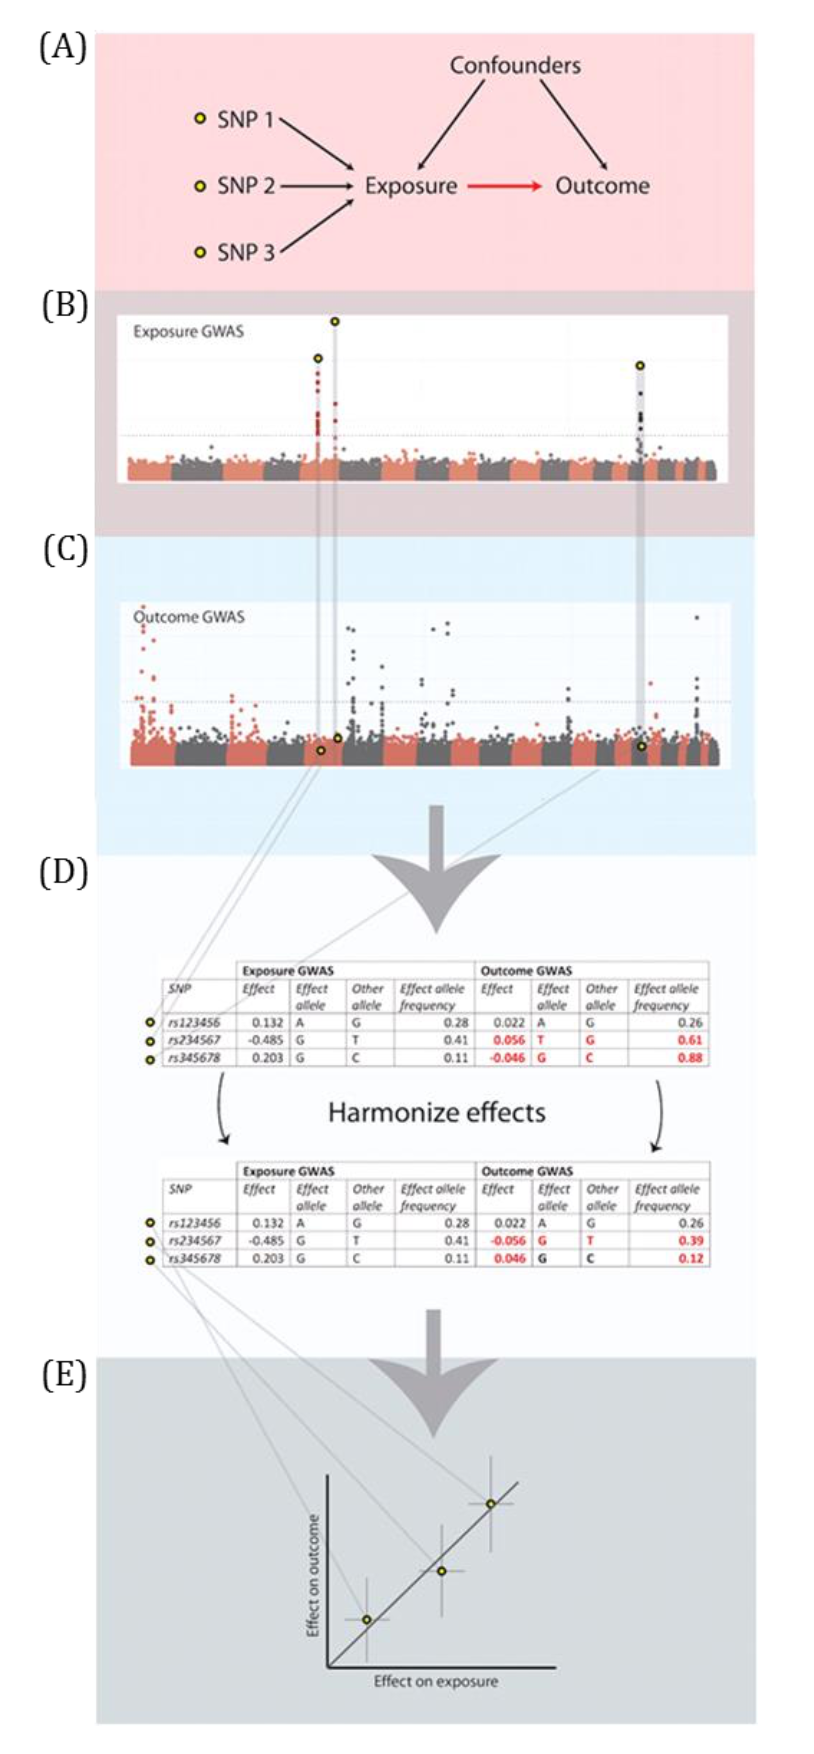